# Importing Required Libraries

In [3]:
class Div:
    def __init__(self, number1, number2):
        self.number1 = number1
        self.number2 = number2 
        assert type(self.number1) == int 
        assert type(self.number2) == int 
        
    def divi(self,number1,number2): 
        
        try:
            results = self.number1 / self.number2
            raise RuntimeError('what the heck? are you dividing by zero?')
        except:
            results = self.number1 / 2
            return results 

diva = Div(number1=12,number2=2)

diva.divi(number1=12,number2=0)


6.0

In [4]:
class Model: 
    def __init__(self,depth,n_trees,random_state): 
        self.depth = depth 
        self.n_trees = n_trees 
        self.random_state = random_state
        
    def params(self,depth, n_trees, random_state):
        params = {'depth': self.depth,
                  'n_trees' : self.n_trees,
                  'random_state': self.random_state}
        if not all(isinstance(value, int) for value in params.values()):
            raise TypeError("All parameters should be integers")
        if params['depth'] > 1000: 
            raise TypeError("Trust me you don't have the cpu for that")
        
        return params

model = Model(100,2,7)
model.params(2,4,7)

{'depth': 100, 'n_trees': 2, 'random_state': 7}

In [5]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import GroupKFold,KFold
from sklearn.preprocessing import LabelEncoder


# Defining Needed Functions

In [6]:
def post_process(test_data,y,feature_to_mean='date_month') -> int:
    """runs the post processing

    Keyword arguments:
    test_data -- the testing data
    y -- the target
    feature_to_mean -- feature to apply the post processing by
    Return: predictions after processing
    """
    test_data['target'] = y
    test_data['target_month'] = test_data[feature_to_mean].map(test_data[[feature_to_mean,'target']].groupby(feature_to_mean)['target'].mean())
    test_data.drop(columns='target',inplace=True)
    return test_data['target_month']

# Reading Data

In [7]:
train = pd.read_csv("/Users/ahmed/Downloads/computerscience/AirQo/PM2.5-Prediction/data/Train.csv")
test = pd.read_csv("/Users/ahmed/Downloads/computerscience/AirQo/PM2.5-Prediction/data/Test.csv")

for df in(train,test):
    df.index = pd.to_datetime(df['date'])

<Axes: xlabel='date'>

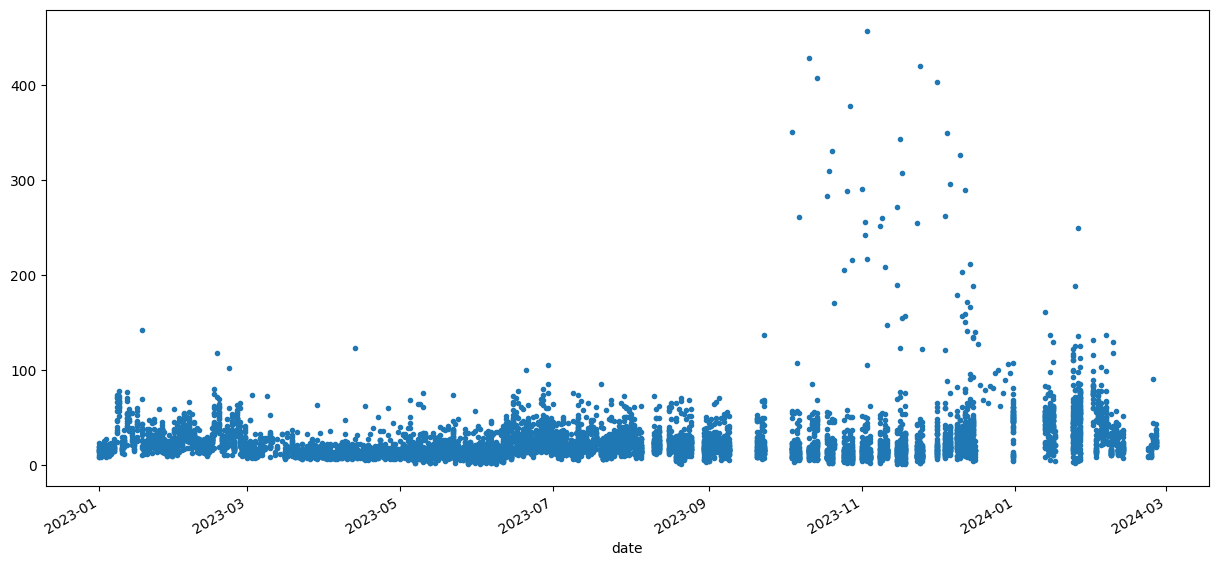

In [8]:
train['pm2_5'].plot(style='.',
                    figsize=(15,7))

<Axes: xlabel='date', ylabel='pm2_5'>

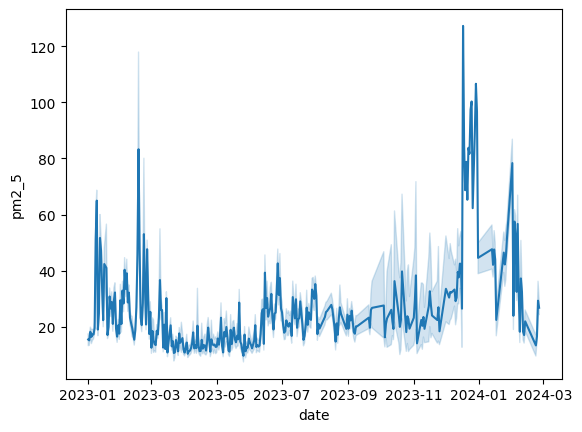

In [9]:
import seaborn as sns 
sns.lineplot(x=train.index,y=train['pm2_5'])

<Axes: ylabel='Frequency'>

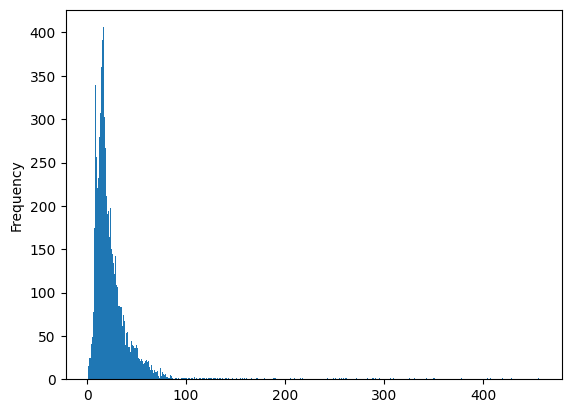

In [10]:
train['pm2_5'].plot(kind='hist',bins=500)

# Cleaning data

In [11]:
def clean(trainset,testset):
    train_feats = trainset.notna().sum()[trainset.notna().sum() > .15*len(trainset)].index
    test_feats = testset.notna().sum()[testset.notna().sum() > .15*len(testset)].index
    trainset = trainset[train_feats]
    testset = testset[train_feats[:-1]]
    
clean(train,test)

In [12]:
train

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
date,,,,,,,,,,,,,,,,,,,,,
2023-10-25,id_vjcx08sz91,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-10-25,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
2023-11-02,id_bkg215syli,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-02,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2023-11-03,id_oui2pot3qd,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-03,13,NaN,NaN,...,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741
2023-11-08,id_9aandqzy4n,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-08,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.537600
2023-11-09,id_ali5x2m4iw,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,...,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,id_ov6ddbfdf0,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-17,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.086071
2024-01-24,id_3tv6i1a09t,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-24,11,-0.000563,0.595788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.110000
2024-01-25,id_csqjqt3f9i,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-25,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.080000


In [13]:
test

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_cloud_top_pressure,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle
date,,,,,,,,,,,,,,,,,,,,,
2023-09-06,id_ihxgrbq8bw,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-06,13,-0.000072,0.762543,...,74217.403083,2710.544562,83569.504246,1710.544483,3.063105,0.263193,-100.317077,27.059646,-86.885670,25.530511
2023-09-07,id_dg6s4fhiwe,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-07,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-08,id_f7hwwtmuzp,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-08,13,-0.000051,1.004265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-09,id_ioese5awdg,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-09,12,NaN,NaN,...,46052.449219,6585.034668,52160.980469,5585.034668,29.145922,0.314945,70.680077,61.874222,-90.875603,11.865201
2023-09-20,id_hdw320zpls,64f9d17ab9e98d001ac9e882,5.61252,-0.22955,Accra,Ghana,2023-09-20,12,-0.000634,0.632173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-27,id_5yblexf7zp,64654b4dd5320e001d6c499a,-0.10098,34.76242,Kisumu,Kenya,2024-01-27,10,0.000099,0.660385,...,59925.188475,4975.111702,67328.459370,3975.111746,2.831732,0.250637,72.428178,55.404121,-150.645025,21.248325
2024-02-21,id_c9cycuvetl,65c8c557b3d86f0012b2e32b,3.89696,11.50603,Yaoundé,Cameroon,2024-02-21,12,NaN,NaN,...,68535.789382,3362.649565,77172.040801,2362.649565,13.719315,0.228072,-101.384688,16.577282,-125.511751,25.086502
2024-02-22,id_8xu1ardxni,65c8c557b3d86f0012b2e32b,3.89696,11.50603,Yaoundé,Cameroon,2024-02-22,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Generating time-related features

In [14]:
train

,id,site_id,site_latitude,site_longitude,city,country,date,hour,sulphurdioxide_so2_column_number_density,sulphurdioxide_so2_column_number_density_amf,...,cloud_cloud_top_height,cloud_cloud_base_pressure,cloud_cloud_base_height,cloud_cloud_optical_depth,cloud_surface_albedo,cloud_sensor_azimuth_angle,cloud_sensor_zenith_angle,cloud_solar_azimuth_angle,cloud_solar_zenith_angle,pm2_5
date,,,,,,,,,,,,,,,,,,,,,
2023-10-25,id_vjcx08sz91,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-10-25,13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.015000
2023-11-02,id_bkg215syli,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-02,12,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.267200
2023-11-03,id_oui2pot3qd,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-03,13,NaN,NaN,...,6791.682888,51171.802486,5791.682829,11.816715,0.192757,-96.411890,61.045123,-121.307414,41.898269,39.450741
2023-11-08,id_9aandqzy4n,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-08,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.537600
2023-11-09,id_ali5x2m4iw,6531a46a89b3300013914a36,6.532570,3.399360,Lagos,Nigeria,2023-11-09,13,0.000267,0.774656,...,1451.050659,96215.906250,451.050598,10.521009,0.153114,-97.811241,49.513439,-126.064453,40.167355,19.431731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-17,id_ov6ddbfdf0,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-17,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.086071
2024-01-24,id_3tv6i1a09t,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-24,11,-0.000563,0.595788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.110000
2024-01-25,id_csqjqt3f9i,647f3a5d69df500029a2fc93,-1.268877,36.819139,Nairobi,Kenya,2024-01-25,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.080000


In [15]:
def feature_engineering(train,test):
    for df in [train, test]:
        df['date'] = pd.to_datetime(df['date'])
        df['date_month'] = df['date'].dt.day_of_year
        df['DayOfWeek'] = df['date'].dt.dayofweek
        df['Day'] = df['date'].dt.day
        df['Year'] = df['date'].dt.year
        df.drop(columns=['id', 'site_id', 'date'], inplace=True)

    # Create lag features for the training data
    train['previous_day_pm2_5_value'] = train.groupby('Day')['pm2_5'].shift(1)
    train['previous_1_week_pm2_5_value'] = train.groupby('Day')['pm2_5'].shift(7)

    # Fill missing lag features with appropriate values (e.g., NaN or other imputation methods)
    train.fillna(method='bfill', inplace=True)

    combined = pd.concat([train, test], sort=False)

    combined['previous_day_pm2_5_value'] = combined.groupby('Day')['pm2_5'].shift(1)
    combined['previous_1_week_pm2_5_value'] = combined.groupby('Day')['pm2_5'].shift(7)

    train = combined[combined.index.isin(train.index)]
    test = combined[combined.index.isin(test.index)]

    test.fillna(method='bfill', inplace=True)

    train.drop(columns=['pm2_5'], inplace=True)
    test.drop(columns=['pm2_5'], inplace=True)


# Label Encodig the features

In [16]:
le = LabelEncoder()
for column in ['city','country']:
    letrans = le.fit_transform(pd.concat([train,test])[column])
    train[column] = letrans[:len(train)]
    test[column] = letrans[len(train):]

# Modeling and Validation

In [17]:
groups = train['city'] # the groups used in grouped kfold
model =  LGBMRegressor(random_state=42,n_estimators=200,max_depth=10,objective='mse')
n_splits = 4
cv = GroupKFold(n_splits=n_splits)

In [18]:
train_set = pd.read_csv("/Users/ahmed/Downloads/computerscience/AirQo/PM2.5-Prediction/data/Train.csv")
test_set = pd.read_csv("/Users/ahmed/Downloads/computerscience/AirQo/PM2.5-Prediction/data/Test.csv")
def validate(trainset,testset,t,origin):
    model.fit(trainset.drop(columns=t),trainset[t])
    pred = model.predict(np.array(testset.drop(columns=t)))
    print('std: ', testset[t].std())

    # to validate the post processing
    origin['pm_5'] = pred
    origin['date'] = pd.to_datetime(origin['date'])
    origin['date_day'] = origin['date'].dt.dayofyear
    pred = origin['date_day'].map(origin[['date_day','pm_5']].groupby('date_day')['pm_5'].mean())
    #--------------------------------------------------------------------------------------------
    stds.append(testset[t].std())
    score = mean_squared_error(pred,testset[t],squared=False)
    print('score:', score)
    return score
stds = []
rmse = []

for v_train,v_test in cv.split(train.drop(columns='pm2_5'),train['pm2_5'],groups=groups):
    train_v, test_v= train.iloc[v_train],train.iloc[v_test]
    origin = train_set.iloc[v_test]
    rmse.append(validate(train_v,test_v,'pm2_5',origin))

ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: id: object, site_id: object, date: object

In [ ]:
np.array(rmse).mean()

27.749077068645054

# Infrence

In [ ]:
model.fit(train.drop(columns='pm2_5'),train['pm2_5'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16520
[LightGBM] [Info] Number of data points in the train set: 8071, number of used features: 73
[LightGBM] [Info] Start training from score 24.639296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMRegressor(max_depth=10, n_estimators=200, objective='mse', random_state=42)

In [ ]:
y = model.predict(test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [ ]:
smaple = pd.read_csv('/Users/ahmed/Downloads/computerscience/AirQo/pm2_5-Prediction/data/SampleSubmission.csv')
smaple['pm2_5'] = post_process(test,y)
smaple.to_csv('submission.csv',index=False)